## This notebook is the code-a-long from the video of Micrograd!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

### From here we start constructing micrograd ourself from scratch

In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __radd__(self, other):
        return self + other


    def __add__(self ,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    




In [3]:
a = Value(5.0)
b = Value(2.0)
c = a**2
d = a - b
print(c)
print(d)

Value(data=25.0)
Value(data=3.0)


In [4]:
import os

# Voeg de map van 'dot' toe aan PATH binnen Python
os.environ["PATH"] += os.pathsep + "/opt/local/bin"

# Daarna pas graphviz gebruiken
from graphviz import Digraph

In [5]:



def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={"rankdir": "LR"}) # LR is left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectengular node for it

        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4r }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # if this value is a result of some operation then create a op node 
            dot.node(name = uid + n._op, label = n._op)
            # and connect the node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot



In [6]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# Bias
b = Value(6.7, label="b")
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "n"

e = (n*2).exp()
o = (e - 1) / (e + 1)
o.label="o"
o.backward()

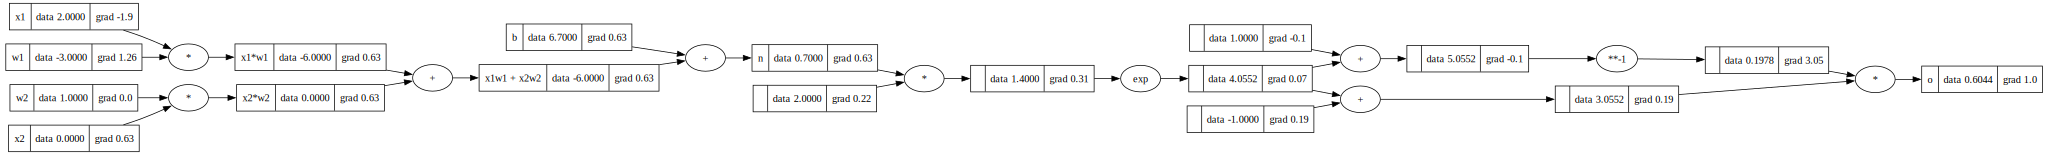

In [7]:
draw_dot(o)

In [10]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # zips (x1 w1) (x2 w2) | raw activation
        out = act.tanh() 
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [12]:
len(n.parameters())

41

In [71]:
n = MLP(3, [4, 4, 1])

In [70]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [6.0, -2.0, -2.0, 1.0]


In [72]:
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    # back propegation
    for p in n.parameters():
        p.grad = 0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.5 * p.grad

    print(k, loss.data)

0 53.73009689059429
1 39.49519951438439
2 54.999894357365044
3 54.9998925459033
4 54.99989066606454
5 54.99988871384022
6 54.9998866849004
7 54.99988457456097
8 54.99988237774652
9 54.99988008894857
10 54.99987770217825
11 54.9998752109127
12 54.99987260803407
13 54.99986988576004
14 54.99986703556425
15 54.99986404808511
16 54.99986091302079
17 54.99985761900807
18 54.999854153481834
19 54.999850502511656


In [73]:
ypred

[Value(data=-0.9999917184070485),
 Value(data=-0.9999999775499007),
 Value(data=-0.99999981231306),
 Value(data=-0.9999915060995349)]